In [1]:
# add path to sispeuede to sys.path in python and turn off warnings
import os, os.path
import pathlib
import sys
import warnings
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

##  I'M LAZY, SO I HAVEN'T INSTALLED 

path_git = pathlib.Path("/Users/fabianfuentes/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    #"sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))
        

path_sisepuede_inputs_database = pathlib.Path("/Users/fabianfuentes/git/sisepuede_inputs.sqlite")              # e.g., "/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite"

import lib.sisepuede_data_constructs as dc             # from sisepuede_data_pipeline

construct = dc.SISEPUEDEDataConstructs(path_output_database = path_sisepuede_inputs_database, )


In [2]:
dir_cur = pathlib.Path(os.getcwd())
input_data = dir_cur.joinpath("input_data")
output_data = dir_cur.joinpath("output_data")

In [3]:
gdp = construct.read_from_output_database(
    "GDP",
    table_type = "historical"
)

gdp.head()

,iso_alpha_3,year,gdp_mmm_usd
0,ABW,1986,1.320771
1,ABW,1987,1.533138
2,ABW,1988,1.818915
3,ABW,1989,2.038912
4,ABW,1990,2.120000


In [4]:
#filter data for Uganda
gdp = gdp[gdp['iso_alpha_3'] == 'UGA']
gdp.describe()


,year,gdp_mmm_usd
count,44.000000,44.000000
mean,2000.500000,42.300549
std,12.845233,30.475254
min,1979.000000,11.098871
25%,1989.750000,15.618110
50%,2000.500000,30.595000
75%,2011.250000,67.097500
max,2022.000000,107.730000


In [5]:
gdp = gdp[gdp['year'] <= 2022].copy() # Filter out future years
gdp.tail()

,iso_alpha_3,year,gdp_mmm_usd
7392,UGA,2018,90.79
7393,UGA,2019,96.64
7394,UGA,2020,99.49
7395,UGA,2021,103.01
7396,UGA,2022,107.73


In [6]:
# Growth rates Uganda Vision 2023-2050
growth_rates = [
    (2023, 2025, 8.35),   # 2023–2025: 8.35% 
    (2026, 2030, 8.22),   # 2026–2030: 8.22% 
    (2031, 2035, 8.07),   # 2031–2035: 8.07% 
    (2036, 2040, 7.83),   # 2036–2040: 7.83% 
    (2041, 2050, 7.83),   # 2041–2050: 7.83% 
    (2051, 2060, 6.83),   # 2051–2060: 6.83%
    (2061, 2070, 3.83),   # 2061–2070: 3.83%
    (2071, 2080, 2.83),   # 2071–2080: 2.83%
    (2081, 2090, 1.83),   # 2081–2090: 1.83%
    (2091, 2100, 1.83)    # 2091–2100: 1.83%
]

# Anualized growth rates
annualized_rates = {}

for start, end, cumulative in growth_rates:
    n_years = end - start + 1
    # Calcular tasa anualizada (como decimal)
    annual_rate = (1 + cumulative / 100) ** (1 / n_years) - 1
    for year in range(start, end + 1):
        annualized_rates[year] = annual_rate


In [7]:
annualized_rates

{2023: 0.027092690643322204,
 2024: 0.027092690643322204,
 2025: 0.027092690643322204,
 2026: 0.015924668515304274,
 2027: 0.015924668515304274,
 2028: 0.015924668515304274,
 2029: 0.015924668515304274,
 2030: 0.015924668515304274,
 2031: 0.015642884632671494,
 2032: 0.015642884632671494,
 2033: 0.015642884632671494,
 2034: 0.015642884632671494,
 2035: 0.015642884632671494,
 2036: 0.01519137892078204,
 2037: 0.01519137892078204,
 2038: 0.01519137892078204,
 2039: 0.01519137892078204,
 2040: 0.01519137892078204,
 2041: 0.007567059267412857,
 2042: 0.007567059267412857,
 2043: 0.007567059267412857,
 2044: 0.007567059267412857,
 2045: 0.007567059267412857,
 2046: 0.007567059267412857,
 2047: 0.007567059267412857,
 2048: 0.007567059267412857,
 2049: 0.007567059267412857,
 2050: 0.007567059267412857,
 2051: 0.006628733441542023,
 2052: 0.006628733441542023,
 2053: 0.006628733441542023,
 2054: 0.006628733441542023,
 2055: 0.006628733441542023,
 2056: 0.006628733441542023,
 2057: 0.0066287334

In [8]:
last_year = gdp['year'].max()
print(f"Last year in the dataset: {last_year}")

last_gdp = gdp.loc[gdp['year'] == last_year, 'gdp_mmm_usd'].values[0]
print(f"Last GDP value in the dataset: {last_gdp}")

Last year in the dataset: 2022
Last GDP value in the dataset: 107.73


In [9]:
# List to store projections
projection = []

# Project from the year after the last data to 2100
for year in range(last_year + 1, 2101):
    rate = annualized_rates.get(year, 0)  # Use 0 if no rate available
    last_gdp *= (1 + rate)
    projection.append({'year': year, 'gdp_mmm_usd': last_gdp})

# Combine observed and projected
gdp_extended = pd.concat([gdp, pd.DataFrame(projection)], ignore_index=True)   

In [10]:
# Calculate annual GDP growth rate
gdp_extended['gdp_growth_rate'] = gdp_extended['gdp_mmm_usd'].pct_change() * 100
gdp_extended.tail()

,iso_alpha_3,year,gdp_mmm_usd,gdp_growth_rate
117,NaN,2096,186.377969,0.18151
118,NaN,2097,186.716264,0.18151
119,NaN,2098,187.055173,0.18151
120,NaN,2099,187.394698,0.18151
121,NaN,2100,187.734838,0.18151


<Axes: xlabel='year'>

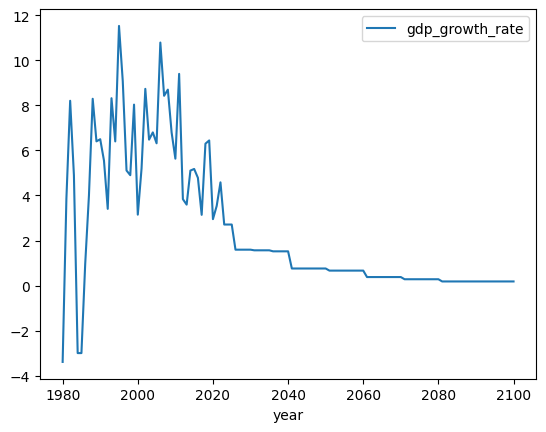

In [11]:
# Plot GDP growth rate
gdp_extended.plot(x = 'year', y='gdp_growth_rate')

<Axes: xlabel='year'>

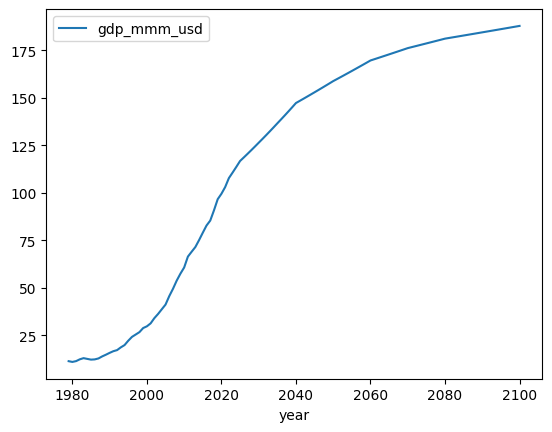

In [12]:
# Plot GDP mmm USD
gdp_extended.plot(x = 'year', y='gdp_mmm_usd')

## Project Uganda’s GDP to 2100 using a log-linear regression

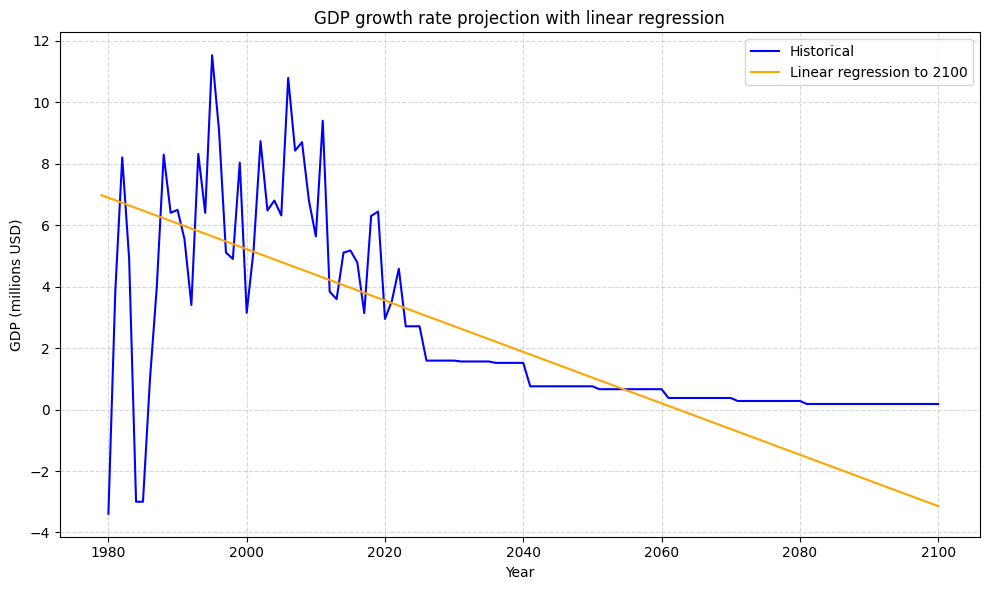

In [13]:

# Filter data from 1981 onwards

X = gdp_extended[(gdp_extended['year'] >= 1981) & (gdp_extended['year'] < 2050)].copy()[['year']]
y = gdp_extended[(gdp_extended['year'] >= 1981) & (gdp_extended['year'] < 2050)].copy()['gdp_growth_rate']

model = LinearRegression()
model.fit(X, y)

future_years = np.arange(gdp_extended['year'].min(), 2101)
future_X = future_years.reshape(-1, 1)
gdp_preds = model.predict(future_X)

gdp_proj_linear = pd.DataFrame({
    'year': future_years,
    'gdp_growth_rate': gdp_preds
})

# Plot
plt.figure(figsize=(10,6))
plt.plot(gdp_extended['year'], gdp_extended['gdp_growth_rate'], label='Historical', color='blue')
plt.plot(gdp_proj_linear['year'], gdp_proj_linear['gdp_growth_rate'], label='Linear regression to 2100', color='orange')
plt.title('GDP growth rate projection with linear regression')
plt.xlabel('Year')
plt.ylabel('GDP (millions USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
# Prepare the final DataFrame with the required columns
gdp_extended = gdp_extended.drop(columns=['iso_alpha_3', 'gdp_growth_rate'])
gdp_extended.tail()

,year,gdp_mmm_usd
117,2096,186.377969
118,2097,186.716264
119,2098,187.055173
120,2099,187.394698
121,2100,187.734838


In [15]:
gdp_extended.to_csv(output_data.joinpath("gdp_mmm_usd.csv"), index=False)